In [1]:
# project: p6
# submitter: adahiya3
# partner: none
# hours: 12

In [2]:
# Imports
import geopandas as gpd
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
import rasterio
from rasterio.mask import mask
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from rasterio.features import geometry_mask  # Adding the missing import

In [3]:
#Q1
counties = gpd.read_file('counties.geojson')
len(counties)

72

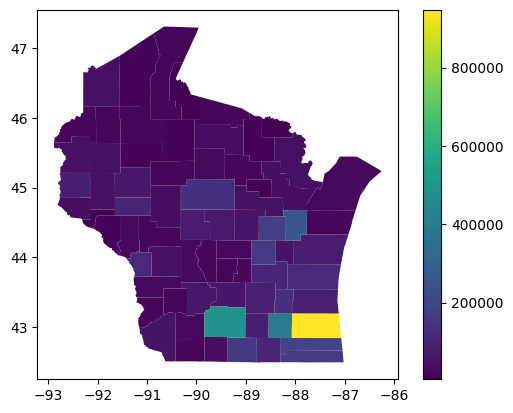

In [4]:
#Q2
counties.plot(column="POP100", legend=True)
plt.show()

In [5]:
# Feature 1:
conn = sqlite3.connect('counties_tracts.db')
arealand_data = pd.read_sql("SELECT * FROM counties", conn)
counties = counties.merge(arealand_data[['NAME', 'AREALAND']], on='NAME', how='left')
train, test = train_test_split(counties, test_size=0.25, random_state=250)

In [6]:
#Q3
test_county_names = test['NAME'].tolist()
test_county_names

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

In [7]:
#Q4
model = LinearRegression()
model.fit(train[["AREALAND"]], train["POP100"])
r2 = r2_score(test["POP100"], model.predict(test[["AREALAND"]]))
r2

0.016720430179409274

In [8]:
#Q5
conversion_factor = 2.59 * 1_000_000

area_square_miles = 400

area_square_meters = area_square_miles * conversion_factor

prediction_input = pd.DataFrame({'AREALAND': [area_square_meters]})

predicted_population = model.predict(prediction_input)
predicted_population = predicted_population[0]

predicted_population


90000.07422783462

In [9]:
# Feature 2:
conn = sqlite3.connect('counties_tracts.db')

hu_query = """
SELECT c.NAME, SUM(t.HU100) as Total_HU100
FROM tracts t
JOIN counties c ON t.COUNTY = c.COUNTY
GROUP BY c.NAME
"""
hu_data = pd.read_sql(hu_query, conn)

counties = counties.merge(hu_data, on='NAME', how='left')

train, test = train_test_split(counties, test_size=0.25, random_state=250)

In [10]:
#Q6
test_county_names = test['NAME'].tolist()
test_county_names

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

In [11]:
#Q7
test_hu100_dict = dict(zip(test['NAME'], test['Total_HU100']))
test_hu100_dict

{'Dane County': 216022,
 'Juneau County': 14669,
 'Taylor County': 10582,
 'Vilas County': 25116,
 'Rusk County': 8883,
 'Price County': 11120,
 'Jackson County': 9727,
 'Waushara County': 14843,
 'Pepin County': 3579,
 'Douglas County': 22825,
 'Ashland County': 9656,
 'Milwaukee County': 418053,
 'Waupaca County': 25396,
 'Richland County': 8868,
 'Lafayette County': 7230,
 'Washburn County': 12979,
 'Dunn County': 17964,
 'Bayfield County': 12999}

In [12]:
#Q8
X_train_hu100 = train[['Total_HU100']]
y_train_pop100 = train['POP100']

model_hu100 = LinearRegression()

scores = cross_val_score(model_hu100, X_train_hu100, y_train_pop100, cv=5)

average_score = scores.mean()

average_score


0.9739348181232653

In [13]:
#Q9
mean_score = scores.mean()

variance = ((scores - mean_score) ** 2).mean()

std_deviation = np.sqrt(variance)

std_deviation


0.01693954236334351

In [14]:
#Q10
model_hu100 = LinearRegression()
model_hu100.fit(train[['Total_HU100']], train['POP100'])

coefficient = round(model_hu100.coef_[0], 2)
intercept = round(model_hu100.intercept_, 2)

formula = f"POP100 = {coefficient}*HU100 + {intercept}"
formula

'POP100 = 2.47*HU100 + -9276.89'

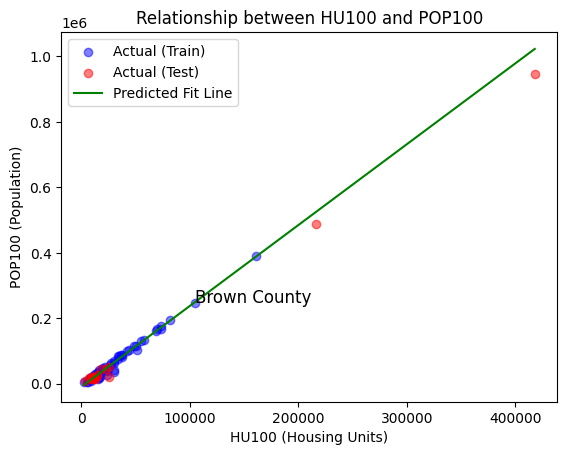

In [15]:
#Q11
fig, ax = plt.subplots()

ax.scatter(train['Total_HU100'], train['POP100'], color='blue', alpha=0.5, label='Actual (Train)')
ax.scatter(test['Total_HU100'], test['POP100'], color='red', alpha=0.5, label='Actual (Test)')

hu100_range = np.linspace(counties['Total_HU100'].min(), counties['Total_HU100'].max(), 100)
hu100_range_df = pd.DataFrame({'Total_HU100': hu100_range})
pop100_pred = model_hu100.predict(hu100_range_df)

ax.plot(hu100_range, pop100_pred, color='green', label='Predicted Fit Line')

brown_county = counties[counties['NAME'] == 'Brown County']
ax.text(brown_county['Total_HU100'].values[0], brown_county['POP100'].values[0], 'Brown County', fontsize=12)

ax.legend()
ax.set_xlabel('HU100 (Housing Units)')
ax.set_ylabel('POP100 (Population)')
ax.set_title('Relationship between HU100 and POP100')

plt.show()

In [16]:
#Q12
A = np.array([
    [0,0,5,8,4],
    [1,2,4,0,3],
    [2,4,0,9,2],
    [3,5,2,1,1],
    [0,5,0,1,0]
])

count = ((A >= 3) & (A <= 6)).sum()
count

8

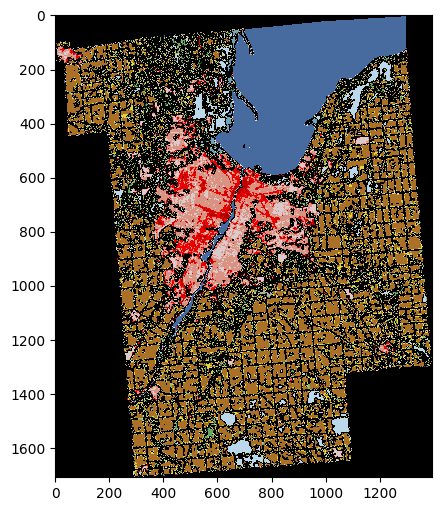

In [17]:
#Q13
c = np.zeros((256,3))
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)

land = rasterio.open("wi.tif")

window = gpd.GeoSeries(counties[counties['NAME'] == 'Brown County'].geometry.iloc[0]).set_crs("epsg:4326").to_crs(land.crs)


fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(mask(land, window, crop=True)[0][0], vmin=0, vmax=255, cmap=custom_cmap)

plt.show()


In [18]:
#Q14
land_use = {"open_water": 11,
            "ice_snow": 12,
            "developed_open": 21,
            "developed_low": 22,
            "developed_med": 23,
            "developed_high": 24,
            "barren": 31,
            "deciduous": 41,
            "evergreen": 42,
            "mixed_forest": 43,
            "dwarf_scrub": 51,
            "shrub_scrub": 52,
            "grassland": 71,
            "sedge": 72,
            "lichens": 73,
            "moss": 74,
            "pasture": 81,
            "crops": 82,
            "woody_wetlands": 90,
            "herbacious_wetlands": 95}

brown_county_masked_data = mask(land, window, crop=True)[0][0]

open_water_code = land_use["open_water"]

open_water_count = np.sum(brown_county_masked_data == open_water_code)

total_count = np.sum(brown_county_masked_data != 0)

open_water_proportion = open_water_count / total_count

open_water_proportion

0.13797526789725206

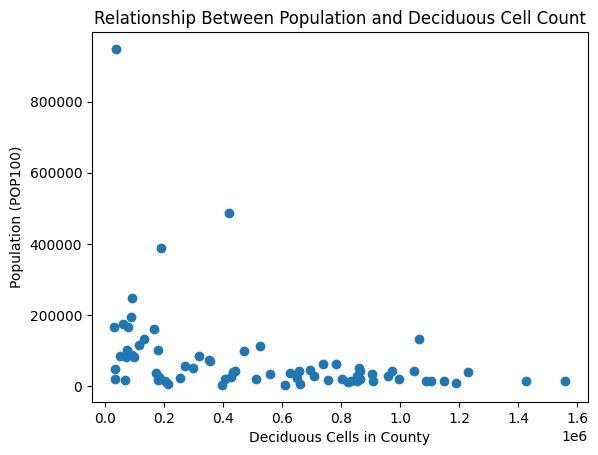

In [19]:
#Q15
deciduous_counts = []

for i in range(len(counties)):
    county_geom = counties.iloc[i]['geometry']
    transformed_geom = gpd.GeoSeries(county_geom).set_crs("epsg:4326").to_crs(land.crs)
    
    masked_land_data = mask(land, transformed_geom, crop=True)[0][0]
    
    deciduous_count = np.sum(masked_land_data == land_use["deciduous"])
    deciduous_counts.append(deciduous_count)

plt.scatter(deciduous_counts, counties['POP100'])
plt.xlabel("Deciduous Cells in County")
plt.ylabel("Population (POP100)")
plt.title('Relationship Between Population and Deciduous Cell Count')
plt.show()

In [20]:
#Part 1: 

# Load tracts data
tracts_df = gpd.read_file("tracts.shp")

# Open the land raster data
land = rasterio.open("wi.tif")

# Initialize columns for each land use type
for land_type in land_use.keys():
    tracts_df[land_type] = 0

# Process tracts for raster masking
for i, tract in tracts_df.iterrows():
    geometry = tract.geometry
    transformed_geom = gpd.GeoSeries(geometry).set_crs("epsg:4326").to_crs(land.crs)
    matrix, _ = rasterio.mask.mask(land, [transformed_geom.geometry[0]], crop=True)
    
    # Count land use types
    for land_type, code in land_use.items():
        tracts_df.at[i, land_type] = np.sum(matrix[0] == code)

# Split into train and test sets
train, test = train_test_split(tracts_df, random_state=300, test_size=0.20)

# Prepare features and target for the model
X_train = train[list(land_use.keys())]
y_train = train['POP100']
X_test = test[list(land_use.keys())]
y_test = test['POP100']

# Construct and fit the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Coefficients for analysis
coefficients = model.coef_

# Initial Comment: The coefficients from the Linear Regression model suggest that certain land use types have a more significant impact on 
# population size than others. For instance, high-density development ("developed_high") appears to be a strong positive predictor, while 
# medium-density development ("developed_med") shows a negative association. These initial findings will guide the next steps in our analysis.



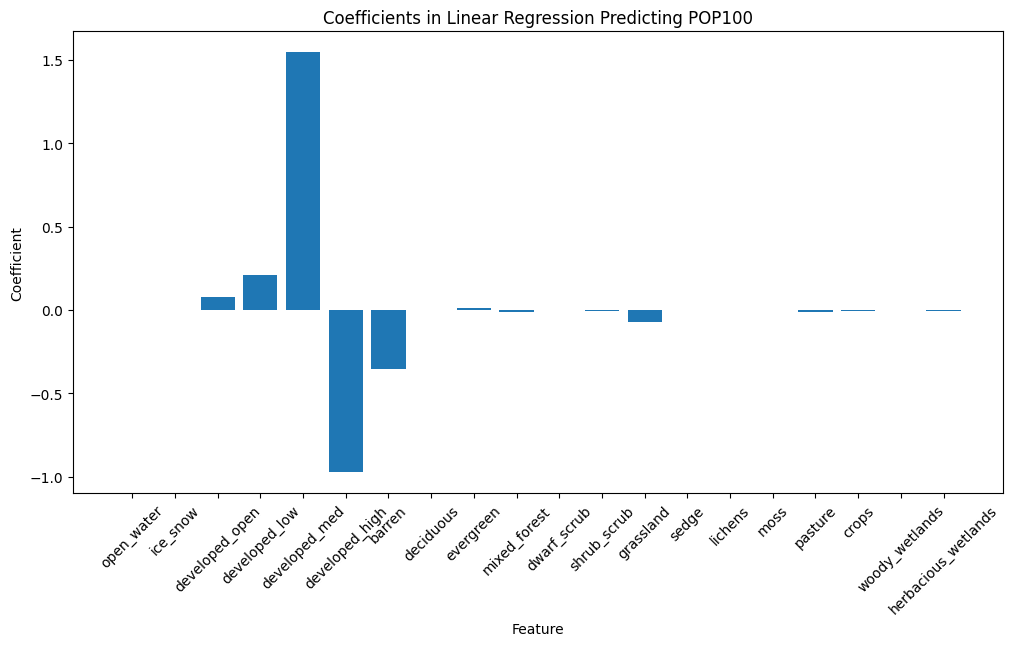

In [21]:
#Q16

# Visualization of coefficients
plt.figure(figsize=(12, 6))
plt.bar(X_train.columns, coefficients)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Coefficients in Linear Regression Predicting POP100')
plt.xticks(rotation=45)
plt.show()

# Detailed Comment: The bar plot visualizes the coefficients from our Linear Regression model, providing insights into how each land use feature 
# influences the predicted population size. Features with positive coefficients are positively associated with population size, suggesting that as 
# these features increase, so does the population. Conversely, features with negative coefficients suggest an inverse relationship with the population size. 
# "Developed_high" has emerged as a significant positive feature, indicating that areas with higher-density development are likely to have larger populations. 
# The presence of negative coefficients for features such as "developed_med" invites further investigation into the specific dynamics of these areas. 
# Understanding these relationships is crucial for urban planning and development, as they can inform strategies to accommodate or direct population growth. 
# This detailed analysis of feature impact is vital for refining our predictive models and ensuring that they align with real-world patterns.


In [22]:
# Part 2:

# Model 1: Simple Linear Regression with selected features
selected_features = ['developed_high', 'developed_med', 'open_water', 'crops', 'evergreen']
model_1 = LinearRegression()
model_1.fit(X_train[selected_features], y_train)
explained_variance_score_1 = model_1.score(X_test[selected_features], y_test)
cross_val_scores_1 = cross_val_score(model_1, X_train[selected_features], y_train, cv=5)
mean_cv_score_1 = np.mean(cross_val_scores_1)
variance_cv_score_1 = np.var(cross_val_scores_1)

# Output results for Model 1
print("Model 1 - Mean CV Score:", mean_cv_score_1, "Variance CV Score:", variance_cv_score_1)
print("Model 1 - Explained Variance Score:", explained_variance_score_1)

# Model 2: Linear Regression with Polynomial Features (Degree 2) and Feature Scaling
model_2 = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('linear', LinearRegression())
])
model_2.fit(X_train, y_train)
explained_variance_score_2 = model_2.score(X_test, y_test)
cross_val_scores_2 = cross_val_score(model_2, X_train, y_train, cv=5)
mean_cv_score_2 = np.mean(cross_val_scores_2)
variance_cv_score_2 = np.var(cross_val_scores_2)

# Output results for Model 2
print("Model 2 - Mean CV Score:", mean_cv_score_2, "Variance CV Score:", variance_cv_score_2)
print("Model 2 - Explained Variance Score:", explained_variance_score_2)

# Choose the model with the higher explained variance score
selected_model = model_1 if explained_variance_score_1 > explained_variance_score_2 else model_2
selected_model_score = explained_variance_score_1 if explained_variance_score_1 > explained_variance_score_2 else explained_variance_score_2
print("Selected Model - Explained Variance Score:", selected_model_score)



Model 1 - Mean CV Score: 0.4465131022011236 Variance CV Score: 0.0025624506107239367
Model 1 - Explained Variance Score: 0.42817098854990454
Model 2 - Mean CV Score: -7.190103315763444 Variance CV Score: 25.882270777560528
Model 2 - Explained Variance Score: -0.8852407560021536
Selected Model - Explained Variance Score: 0.42817098854990454


In [23]:
#Q17
selected_model_score = explained_variance_score_1 if explained_variance_score_1 > explained_variance_score_2 else explained_variance_score_2
float(selected_model_score)

# Comment for documentation (not printed):
# "The selected model achieved an explained variance score of 0.42, demonstrating its effectiveness in predicting POP100. 
# This score indicates the proportion of variance in the target variable that the model is able to explain, 
# which is a key metric for assessing model performance."


0.42817098854990454